In [1]:
import argparse
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
reactions = ['C00092 + C00006 <=> C01236 + C00005',
             'C01236 + C00001 <=> C00345',
             'C00345 + C00006 <=> C00199 + C00011 + C00005']
reactions = list(map(Reaction.parse_formula, reactions))
fluxes = [1.0, 1.0, 1.0]
dG0_r_primes = list(map(lambda rxn: rxn.dG0_prime(), reactions))
bounds = Bounds(default_lb=1e-6, default_ub=1e-2)
pp = Pathway(reactions, fluxes, dG0_r_primes, bounds=bounds)

mdf_data = pp.calc_mdf()

 Simple $\Delta G'^\circ$ calculations

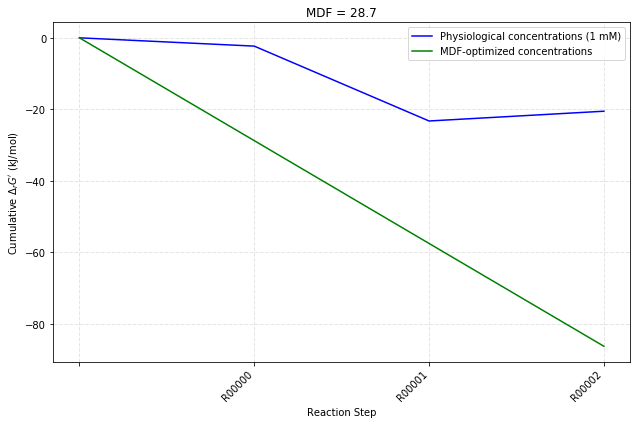

In [7]:
x = mdf_data.mdf_plot

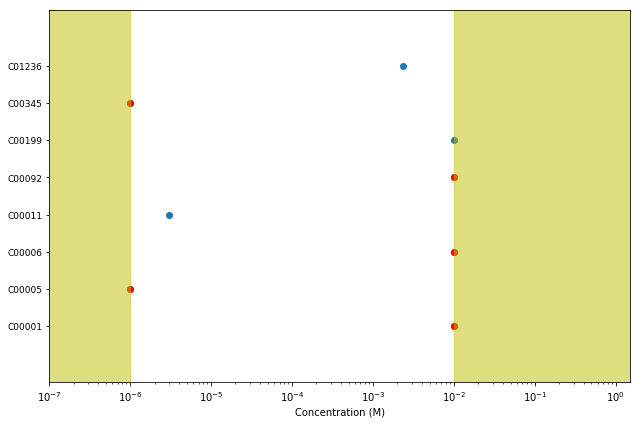

In [4]:
import matplotlib.pyplot as plt

ys = np.arange(0, len(mdf_data.compound_data))
concs = np.array([c.concentration for c in mdf_data.compound_data], ndmin=2)
cnames = [str(c.compound) for c in mdf_data.compound_data]
default_lb = mdf_data.model.concentration_bounds.default_lb
default_ub = mdf_data.model.concentration_bounds.default_ub

cids = [str(c.compound) for c in mdf_data.compound_data]
lbs = [mdf_data.model.concentration_bounds.GetLowerBound(cid)
       for cid in cids]
ubs = [mdf_data.model.concentration_bounds.GetUpperBound(cid)
       for cid in cids]
lbs, ubs = np.array(lbs), np.array(ubs)
bounds_equal = np.where(lbs == ubs)
ys_equal = ys[bounds_equal]
concs_equal = concs[bounds_equal]

# Special color for metabolites with nonzero shadow prices.
shadow_prices = np.array([c.shadow_price for c in mdf_data.compound_data], ndmin=2)
nz_shadow = np.where(shadow_prices != 0)[0]
ys_nz_shadow = ys[nz_shadow]
concs_nz_shadow = concs[nz_shadow]

conc_figure, ax = plt.subplots(1, 1, figsize=(9, 6))
#ax = plt.axes([0.2, 0.1, 0.7, 0.8])
ax.axvspan(1e-8, default_lb, color='y', alpha=0.5)
ax.axvspan(default_ub, 1e3, color='y', alpha=0.5)
ax.scatter(concs, ys,
           label='Variable Concentrations')
ax.scatter(concs_equal, ys_equal, color='y',
           label='Fixed Concentrations')
ax.scatter(concs_nz_shadow, ys_nz_shadow,
           color='r', label='Variable Concentrations')

ax.set_yticks(ys)
ax.set_yticklabels(cnames, fontsize=9)
ax.set_xlabel('Concentration (M)')
ax.set_xscale('log')

ax.set_xlim(default_lb*0.1, 1.5)
ax.set_ylim(-1.5, len(mdf_data.compound_data) + 0.5)

conc_figure.tight_layout()


Cumulative $\Delta_r G'\$ (kJ/mol)

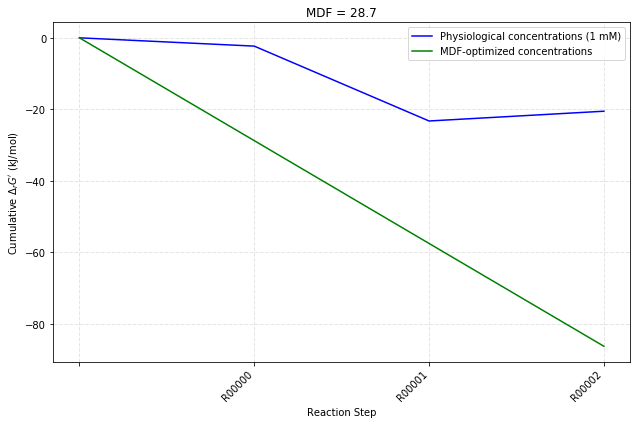

In [5]:
import matplotlib.pyplot as plt

dgms = [0] + [r.dGm for r in mdf_data.reaction_data]
cumulative_dgms = np.cumsum(dgms)

dgs = [0] + [r.dGr for r in mdf_data.reaction_data]
cumulative_dgs = np.cumsum(dgs)

xticks = np.arange(0, len(cumulative_dgs))
xticklabels = [''] + [r.reaction.reaction_id for r in mdf_data.reaction_data]

mdf_fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(cumulative_dgms, label='Physiological concentrations (1 mM)',
        color='blue')
ax.plot(cumulative_dgs, label='MDF-optimized concentrations',
        color='green')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
ax.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)

ax.set_xlabel('Reaction Step')
ax.set_ylabel(r'Cumulative $\Delta_r G^\prime$ (kJ/mol)')
ax.legend(loc='best')
ax.set_title('MDF = %.1f' % mdf_data.mdf)

mdf_fig.tight_layout()

